# Desafio parte 2, 
## Team 2: Francisco de Asis dos Santos Silva, Josué Marinho Hinrichs and Leidy Milena Leal Abril



In this notebook, we use machine learning to create a model with the ability of classifying text of the financial sector as positive, negative or neutral sentiments. In the first section, we shall show the exploratory analysis of data including the information of dataset, verification of missing or repeated values, sentiments distributions and the words more commons. Also, we shall plot figures corresponding. In the second part, we shall clean up data carrying out tokenization and removing the stop words. 


We import the library and packages:

In [4]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/leidy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We import the dataset used to train the model:

In [6]:
dataset = pd.read_csv('./data.csv')
dataset.head(5)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## a) Exploratory analysis

#### - Initial analysis of data:
We use info() to obtain the total number of columns and raws as well as the type:

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


#### - Verifying missing values. 
If there are some missing values we shall remove the corresponding row in the next item.

In [8]:
valores_faltantes = dataset.isnull().sum()
print(valores_faltantes)

Sentence     0
Sentiment    0
dtype: int64


#### - Description of data:
We use describe() to obtain information more detailed about the dataset:

In [9]:
dataset.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


#### - Verifying repeated rows?
If there are repeated rows we shall remove in the next section.

In [313]:
duplicates=dataset.duplicated(keep=False)
duplicate_rows=dataset[duplicates]
duplicate_rows

,Sentence,Sentiment,length_text


#### - Sentiments distribution:
We count the type of sentiments and determine the percentage of each sentiment. Also, we plot a histogram to show the results:

/tmp/ipykernel_35985/1824531122.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  figure=sns.countplot(x=dataset['Sentiment'],order=dataset['Sentiment'].value_counts(ascending=False).index,palette="CMRmap_r",saturation=0.9)


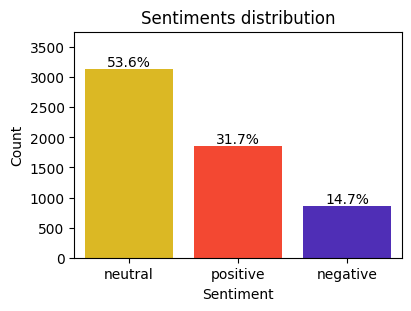

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

In [12]:
fig=plt.figure(figsize=(4,3),constrained_layout=True)
#c=sns.countplot(x='Sentiment', data=dataset,palette="CMRmap_r",saturation=1)
figure=sns.countplot(x=dataset['Sentiment'],order=dataset['Sentiment'].value_counts(ascending=False).index,palette="CMRmap_r",saturation=0.9)
total=dataset['Sentiment'].count()
for i in range(3):
    figure.bar_label(figure.containers[i],fmt=lambda x: f'{(x/total)*100:0.1f}%')
figure.margins(y=0.2)
figure.set(xlabel='Sentiment',ylabel='Count',title='Sentiments distribution')
plt.savefig('Sentiments_distribution.png',dpi=300)
plt.show()

dataset['Sentiment'].value_counts()

#### Exploring the length of texts (string):
We obtain statistical information about the first column i.e about 'Sentences':

In [29]:
dataset['length_text'] = dataset['Sentence'].apply(len)
dataset['length_text'].describe()

count    5842.000000
mean      117.020712
std        56.417790
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: length_text, dtype: float64

##### Boxplot of the full text:

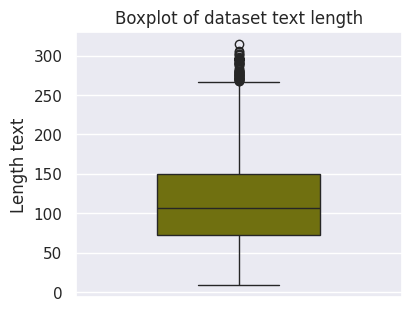

In [68]:
fig=plt.figure(figsize=(4,3),constrained_layout=True)
figure=sns.boxplot(dataset['length_text'],color='olive',width=0.5)
figure.set(ylabel='Length text',title='Boxplot of dataset text length')
plt.savefig('Boxplot_datasetTextLength.png',dpi=300)
plt.show()

##### Histograma

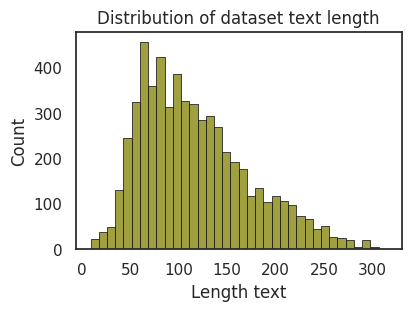

In [84]:
fig=plt.figure(figsize=(4,3),constrained_layout=True)
sns.set_theme(style='white')
figure=sns.histplot(dataset['length_text'],color='olive',ec='k')
figure.set(xlabel='Length text',ylabel='Count',title='Distribution of dataset text length')
plt.savefig('Histogram_datasetTextLength.png',dpi=300)
plt.show()
#

### - Length of the text by group:
We classify the text by sentiment and obtain the length of the text:

/tmp/ipykernel_35985/3891342735.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  figure=sns.boxplot(x=dataset['Sentiment'],y=dataset['Sentence'].apply(len),order=dataset['Sentiment'].value_counts(ascending=False).index,width=0.5,palette="CMRmap_r",saturation=0.9)


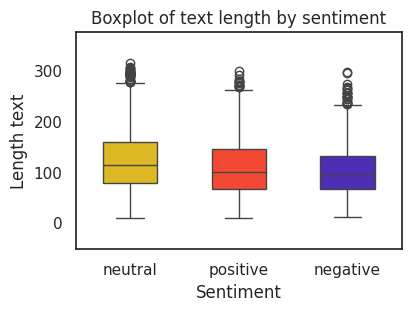

In [117]:
def extract(dataset,sentiment):
    grouped=dataset.groupby(dataset.Sentiment)
    type_sentiment=grouped.get_group(sentiment)
    TLsentiment = type_sentiment['Sentence'].apply(len)
    return TLsentiment


fig=plt.figure(figsize=(4,3),constrained_layout=True)
figure=sns.boxplot(x=dataset['Sentiment'],y=dataset['Sentence'].apply(len),order=dataset['Sentiment'].value_counts(ascending=False).index,width=0.5,palette="CMRmap_r",saturation=0.9)
figure.set(ylabel='Length text',title='Boxplot of text length by sentiment')
figure.margins(y=0.2)

plt.savefig('Boxplot_groupTextLength.png',dpi=300)
#plt.show()


### Words most common:

In [183]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
dataset_tokens = []
stopwords = nltk.corpus.stopwords.words('english')
#print(stopwords)
for entry in dataset['Sentence']:
    tokens = nltk.tokenize.word_tokenize(entry) 
    word_norm=[word.lower() for word in tokens if word.isalpha()]
    rows=[word for word in word_norm if word not in stopwords]
    dataset_tokens.append(rows)

words_only=[]
for entry in dataset_tokens:
    words_only.extend(entry)
freq_words=nltk.FreqDist(words_only)
freq_words

[nltk_data] Downloading package stopwords to /home/leidy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/leidy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


FreqDist({'eur': 1284, 'company': 809, 'mn': 729, 'profit': 568, 'sales': 560, 'finnish': 527, 'said': 516, 'net': 499, 'million': 493, 'operating': 371, ...})

#### Figure of distribution of the words

## b) Cleaning up data:

### - Removing the repeated rows:

In [ ]:
dataset = dataset.drop_duplicates(keep='last')

### - Tokenizing and removing the stop words: